In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import os
import csv
import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)
mp_drawing = mp.solutions.drawing_utils

def detect_body_keypoints(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipped: {image_path} - Unable to load image.")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(image_rgb)

    keypoints_data = []
    if results.pose_landmarks:
        landmarks = results.pose_landmarks
        for landmark in landmarks.landmark:
            keypoints_data.extend([landmark.x, landmark.y, landmark.z])
        return keypoints_data
    else:
        return None

def store_image_keypoints(folder_path, output_filename):
    with open(output_filename, mode='w', newline='') as csvfile:
        fieldnames = ['file_name'] + [f'Keypoint_{i}_x' for i in range(1, 34)] + \
                     [f'Keypoint_{i}_y' for i in range(1, 34)] + \
                     [f'Keypoint_{i}_z' for i in range(1, 34)]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                image_path = os.path.join(folder_path, filename)
                keypoints = detect_body_keypoints(image_path)

                if keypoints is not None:
                    row = {'file_name': filename}
                    for i in range(1, 34):
                        x_index = (i - 1) * 3
                        y_index = x_index + 1
                        z_index = x_index + 2
                        if len(keypoints) > z_index:
                            row[f'Keypoint_{i}_x'] = keypoints[x_index]
                            row[f'Keypoint_{i}_y'] = keypoints[y_index]
                            row[f'Keypoint_{i}_z'] = keypoints[z_index]
                        else:
                            row[f'Keypoint_{i}_x'] = None
                            row[f'Keypoint_{i}_y'] = None
                            row[f'Keypoint_{i}_z'] = None

                    writer.writerow(row)

folder_path = '/folder/containing/images'
output_filename = 'csv/to store/keypoints.csv'

store_image_keypoints(folder_path, output_filename)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

data = pd.read_csv('/stored/keypoints/csv/file.csv')

class_label_mapping = {label: idx for idx, label in enumerate(data['class_name'].unique())}

X = data.drop(['class_no', 'class_name'], axis=1)

data['class_name'] = data['class_name'].map(class_label_mapping)

y_class_no = data['class_no']
y_class_name = data['class_name']


X_train, X_test, y_train_class_no, y_test_class_no, y_train_class_name, y_test_class_name = train_test_split(
    X, y_class_no, y_class_name, test_size=0.2, random_state=42
)

model_class_no = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=39,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

model_class_no.fit(X_train, y_train_class_no, eval_metric=["merror", "mlogloss"], eval_set=[(X_test, y_test_class_no)], verbose=True)


joblib.dump(model_class_no, 'model_class_no.pkl')

model_class_name = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=39,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)


model_class_name.fit(X_train, y_train_class_name, eval_metric=["merror", "mlogloss"], eval_set=[(X_test, y_test_class_name)], verbose=True)

joblib.dump(model_class_name, 'model_class_name.pkl')

loaded_model_class_no = joblib.load('model_class_no.pkl')
loaded_model_class_name = joblib.load('model_class_name.pkl')

y_pred_class_no = loaded_model_class_no.predict(X_test)
y_pred_class_name = loaded_model_class_name.predict(X_test)

accuracy_class_no = accuracy_score(y_test_class_no, y_pred_class_no)
print(f'Final Accuracy (class_no): {accuracy_class_no:.2f}')

class_report_class_no = classification_report(y_test_class_no, y_pred_class_no)
print(class_report_class_no)


accuracy_class_name = accuracy_score(y_test_class_name, y_pred_class_name)
print(f'Final Accuracy (class_name): {accuracy_class_name:.2f}')


class_report_class_name = classification_report(y_test_class_name, y_pred_class_name)
print(class_report_class_name)


[0]	validation_0-merror:0.17647	validation_0-mlogloss:2.72487
[1]	validation_0-merror:0.17647	validation_0-mlogloss:2.28069
[2]	validation_0-merror:0.17647	validation_0-mlogloss:2.00720
[3]	validation_0-merror:0.11765	validation_0-mlogloss:1.80140
[4]	validation_0-merror:0.11765	validation_0-mlogloss:1.64038
[5]	validation_0-merror:0.11765	validation_0-mlogloss:1.51260
[6]	validation_0-merror:0.11765	validation_0-mlogloss:1.40239
[7]	validation_0-merror:0.11765	validation_0-mlogloss:1.31248
[8]	validation_0-merror:0.11765	validation_0-mlogloss:1.24168
[9]	validation_0-merror:0.11765	validation_0-mlogloss:1.17759
[10]	validation_0-merror:0.11765	validation_0-mlogloss:1.11504


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-merror:0.11765	validation_0-mlogloss:1.06439
[12]	validation_0-merror:0.11765	validation_0-mlogloss:1.00847
[13]	validation_0-merror:0.11765	validation_0-mlogloss:0.96835
[14]	validation_0-merror:0.11765	validation_0-mlogloss:0.93238
[15]	validation_0-merror:0.11765	validation_0-mlogloss:0.89423
[16]	validation_0-merror:0.11765	validation_0-mlogloss:0.86156
[17]	validation_0-merror:0.11765	validation_0-mlogloss:0.83672
[18]	validation_0-merror:0.11765	validation_0-mlogloss:0.81149
[19]	validation_0-merror:0.11765	validation_0-mlogloss:0.78766
[20]	validation_0-merror:0.11765	validation_0-mlogloss:0.76877
[21]	validation_0-merror:0.11765	validation_0-mlogloss:0.75497
[22]	validation_0-merror:0.11765	validation_0-mlogloss:0.74361
[23]	validation_0-merror:0.11765	validation_0-mlogloss:0.73608
[24]	validation_0-merror:0.17647	validation_0-mlogloss:0.72670
[25]	validation_0-merror:0.17647	validation_0-mlogloss:0.72154
[26]	validation_0-merror:0.17647	validation_0-mlogloss:

keypoints are stored in the csv file
Predicted class names (class_name): ['falling']


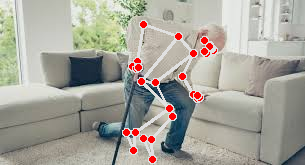

In [ ]:
import os
import csv
import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)
mp_drawing = mp.solutions.drawing_utils

def detect_body_keypoints(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipped: {image_path} - Unable to load image.")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(image_rgb)

    keypoints_data = []
    if results.pose_landmarks:
        landmarks = results.pose_landmarks
        for landmark in landmarks.landmark:
            keypoints_data.extend([landmark.x, landmark.y, landmark.z])
        return keypoints_data
    else:
        return None

def store_image_keypoints(image_path, output_filename):
    with open(output_filename, mode='w', newline='') as csvfile:
        fieldnames = [f'Keypoint_{i}_x' for i in range(1, 34)] + \
                     [f'Keypoint_{i}_y' for i in range(1, 34)] + \
                     [f'Keypoint_{i}_z' for i in range(1, 34)]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        keypoints = detect_body_keypoints(image_path)

        if keypoints is not None:
            row = {}
            for i in range(1, 34):
                x_index = (i - 1) * 3
                y_index = x_index + 1
                z_index = x_index + 2
                if len(keypoints) > z_index:
                    row[f'Keypoint_{i}_x'] = keypoints[x_index]
                    row[f'Keypoint_{i}_y'] = keypoints[y_index]
                    row[f'Keypoint_{i}_z'] = keypoints[z_index]
                else:
                    row[f'Keypoint_{i}_x'] = None
                    row[f'Keypoint_{i}_y'] = None
                    row[f'Keypoint_{i}_z'] = None

            writer.writerow(row)
image_path = 'sample/image/image.jpg'  # Replace with your image path
output_filename = 'csv/path/u need to provide/filename.csv'

store_image_keypoints(image_path, output_filename)
print("keypoints are stored in the csv file")

import pandas as pd
import xgboost as xgb
import joblib

new_data = pd.read_csv('/content/keypoints_efd.csv')

loaded_model_class_no = joblib.load('model_class_no.pkl')
loaded_model_class_name = joblib.load('model_class_name.pkl')

X_new = new_data

predictions_class_name = loaded_model_class_name.predict(X_new)

reverse_class_label_mapping = {idx: label for label, idx in class_label_mapping.items()}

predicted_class_names = [reverse_class_label_mapping[pred] for pred in predictions_class_name]

print("Predicted class names (class_name):", predicted_class_names)

import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

image_path = image_path
image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    results = pose.process(image_rgb)

if results.pose_landmarks is not None:
    mp_drawing = mp.solutions.drawing_utils
    image_with_landmarks = image.copy()
    mp_drawing.draw_landmarks(image_with_landmarks, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2_imshow(image_with_landmarks)
else:
    print("No landmarks detected in the image.")
